
# Quiver Plots & Movies

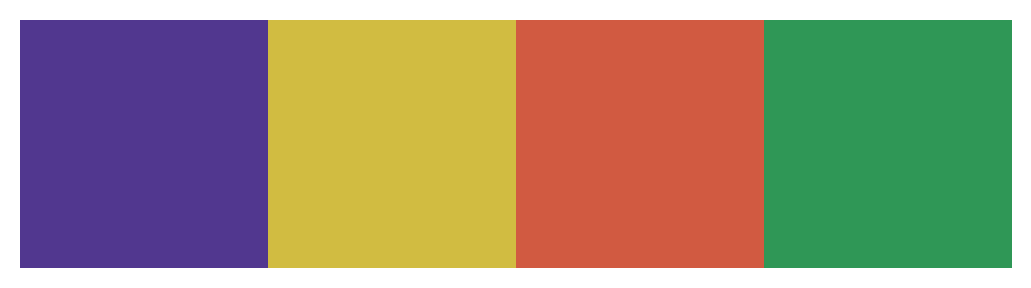

In [81]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

from pathlib import Path
import subprocess

import matplotlib.pyplot as plt
import cmocean
from tqdm.auto import tqdm
from IPython.display import Video

import dustpy
import dustpy.constants as c
from plot_helper import plot_quiver, read_paletton_text, plot_size_distri, get_transparent_cmap
import helper

# Read the paletton color file

colors = (read_paletton_text()[[3,0,2,1], 0, :]/255).tolist()
plt.imshow([colors]).axes.axis('off');

In [89]:
reader = dustpy.hdf5writer()
data_dir = Path('~').expanduser() / 'DATA/araa_data/lowres_highvf/data_bump'
# data_dir = Path('data_bump')
reader.datadir = str(data_dir)
files = reader.read.listfiles()
times = reader.read.sequence('t') / c.year
file = Path(files[np.abs(times - 1e6).argmin()])

sim = reader.read.output(str(file))

(0.0001, 1.0)

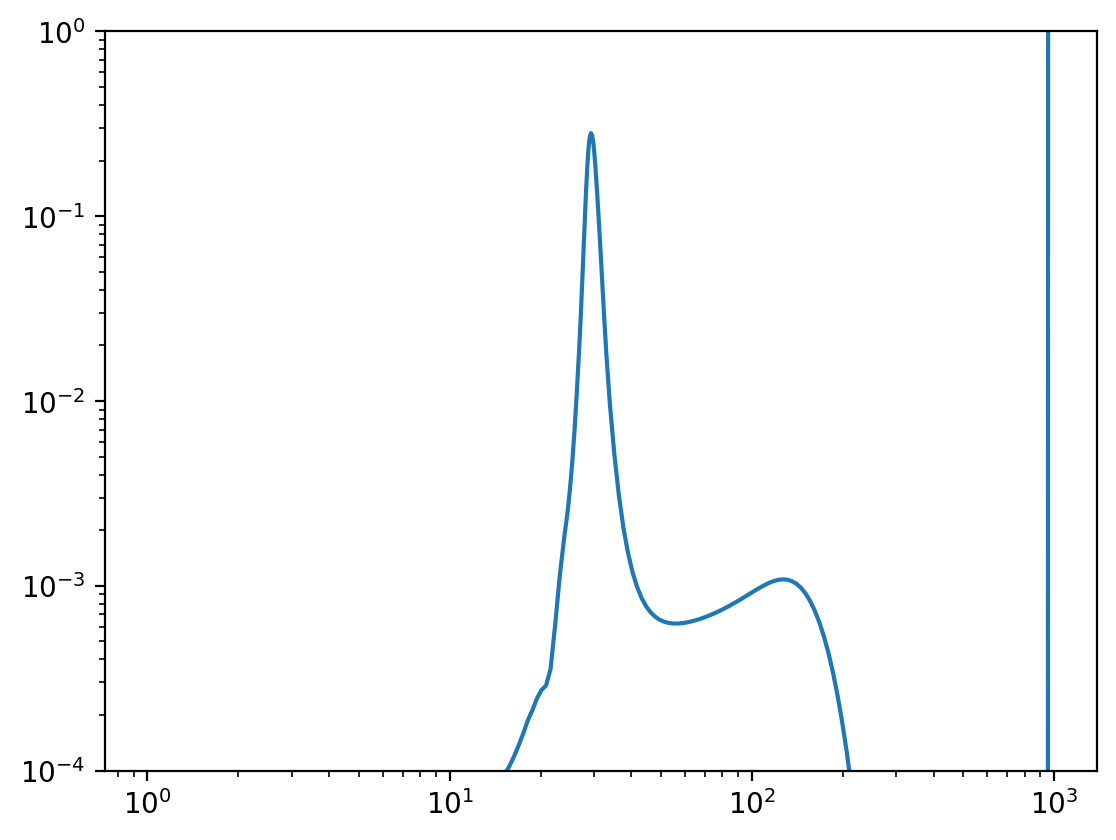

In [90]:
f, ax = plt.subplots()
ax.loglog(sim.grid.r / c.au, sim.dust.eps)
ax.set_ylim(1e-4, 1e0)

## Make a PDF

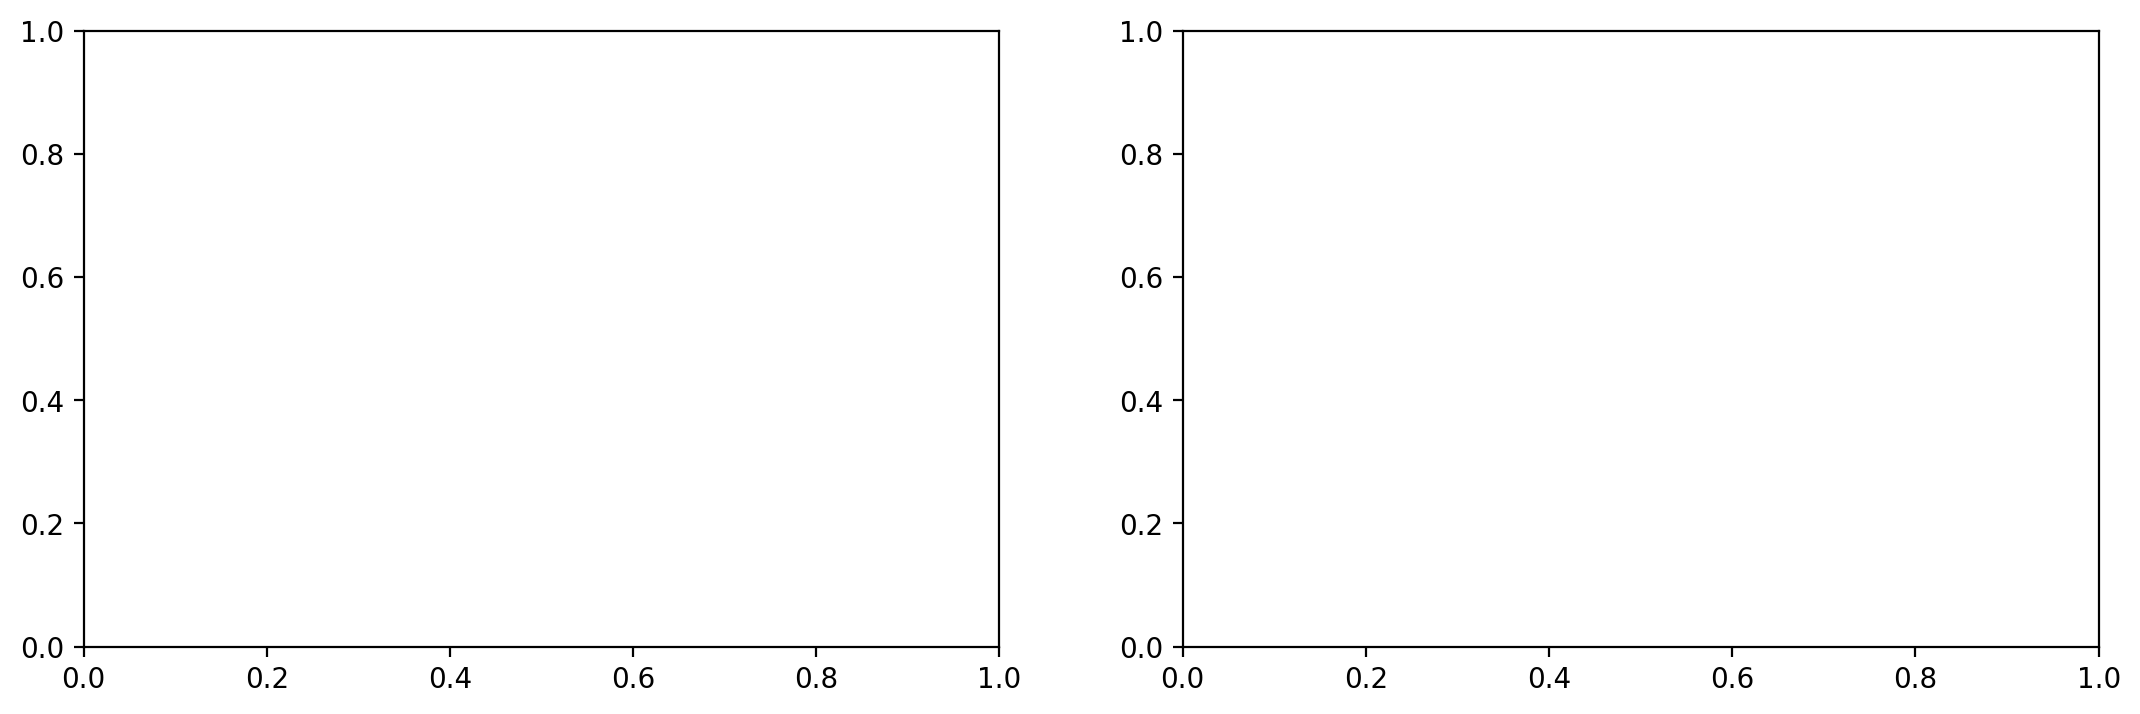

In [91]:
f, axs = plt.subplots(1, 2, figsize=(13, 4), gridspec_kw={'wspace':0.2});

In [92]:
ax = plot_size_distri([str(file) for file in files],
                      radii_au=[3, 30, 100],
                      times=[1e4, 1e5, 1e6, 2e6, 3e6],
                      legend=True,
                      cols=colors, figsize=(6.4, 4), ax=axs[1])
ax.set_facecolor('none')
helper.apply_araa_style(ax)
#ax.figure.savefig(helper.output_dir / f'size_distribution_{Path(reader.datadir).name}.pdf', transparent=True, bbox_inches='tight')

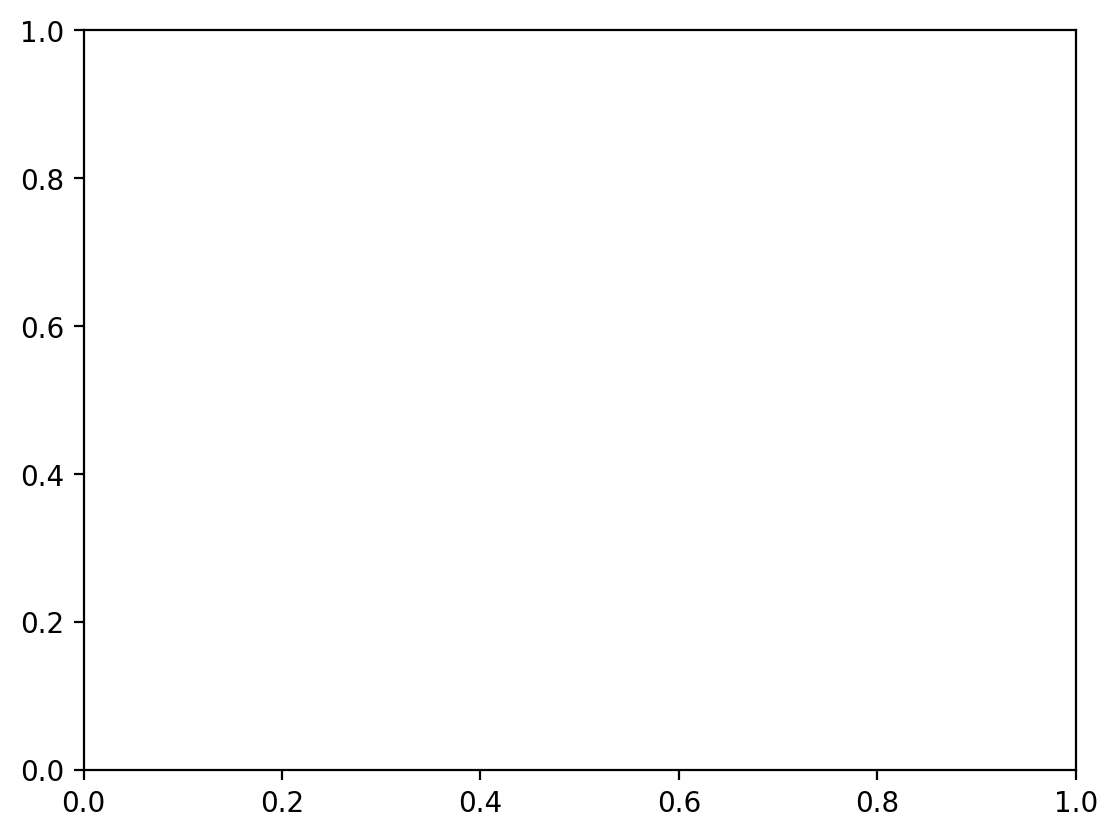

In [93]:
output_file = helper.output_dir / file.with_suffix('.pdf').name.replace('data', 'frame_' + file.parent.name.replace('data_', '') + '_')
f, ax, sols = plot_quiver(str(file), vmin=1e-8, cmap='cmo.algae', cols=colors, figsize=(6.4, 4), ax=axs[0])
ax.set_facecolor('none')
ax.set_xlim(right=300)
helper.apply_araa_style(ax)
#f.savefig(output_file, transparent=True)

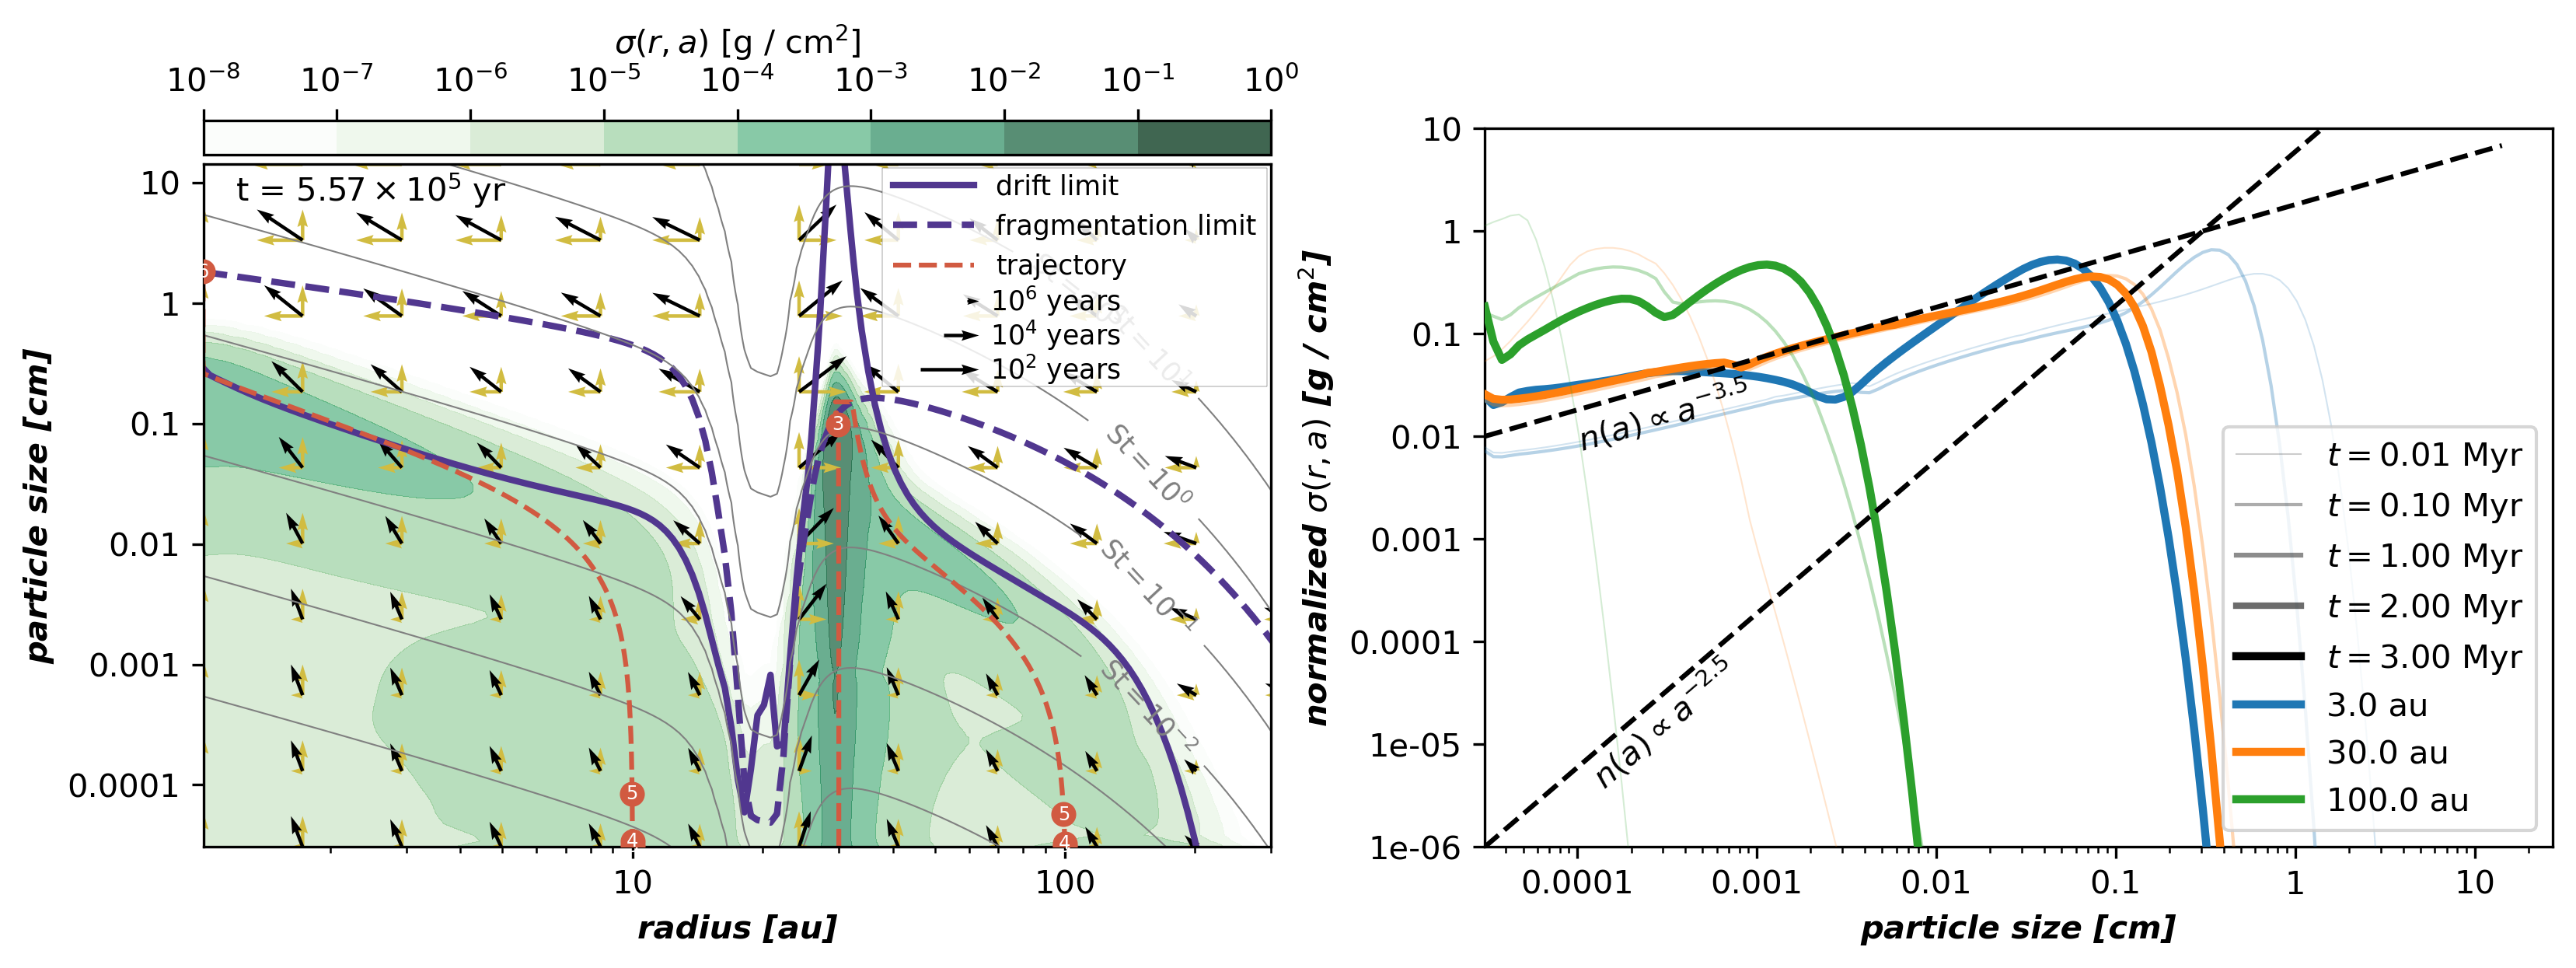

In [94]:
f.dpi=150
f

In [95]:
f.savefig(output_file, transparent=True, bbox_inches='tight')

In [96]:
!open {helper.output_dir}

### Bouncing barrier

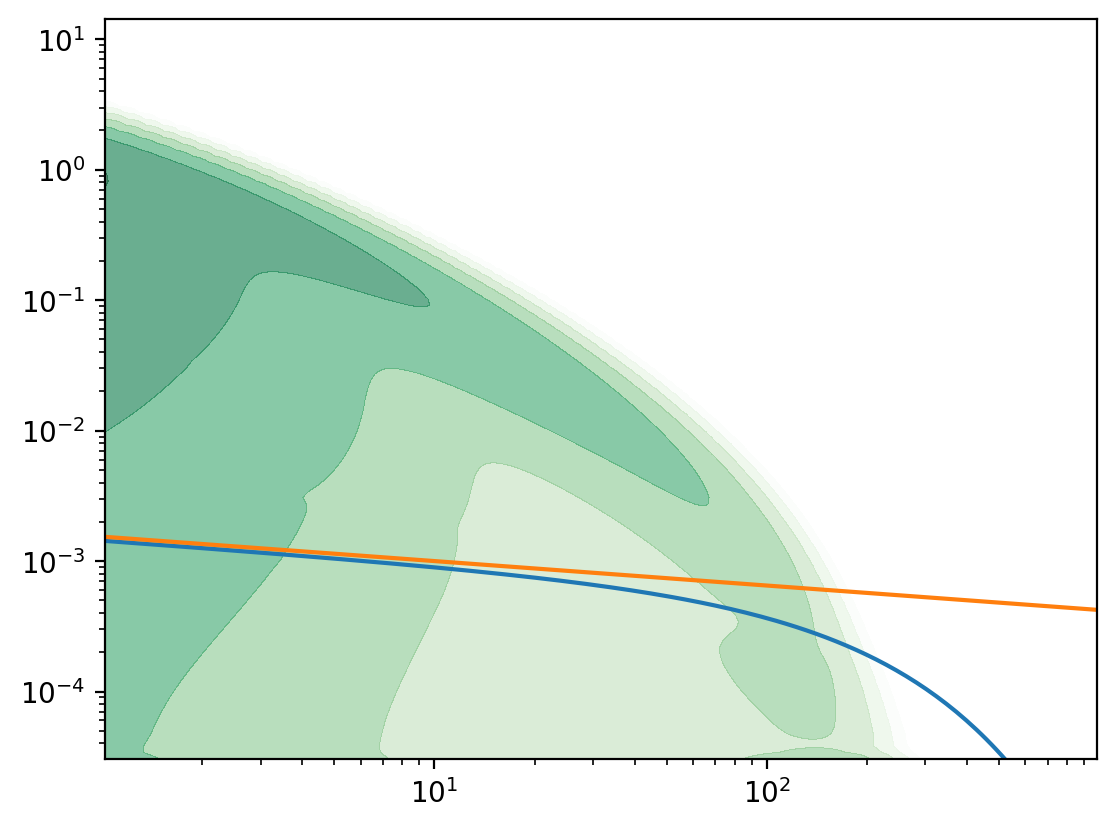

In [215]:
from matplotlib.colors import LogNorm
ab = (3 * 3.3e-3 / (4*np.pi*sim.dust.rhos.mean()))**(1/3)
a_bounce = ab * (2 / (3 * np.pi) * sim.gas.Sigma / (sim.gas.alpha * ab * sim.dust.rhos.mean() * sim.gas.cs**2))**(18/48)

A = np.mean(sim.grid.m[1:] / sim.grid.m[:-1])
B = 2 * (A - 1) / (A + 1)

f, ax = plt.subplots()
ax.contourf(sim.grid.r / c.au, sim.dust.a[0], sim.dust.Sigma.T / B,
            norm=LogNorm(1e-8, 1e1),
            levels=10.**np.arange(-8, 2), cmap=get_transparent_cmap('cmo.algae'))
ax.loglog(sim.grid.r / c.au, a_bounce)
ax.loglog(sim.grid.r / c.au, 1e-3 * (sim.grid.r / (10*c.au))**(-9/48))

# Mass evolution

In [17]:
data_dirs = list((Path('~').expanduser() / 'DATA/araa_data/lowres_highvf').glob('data_*'))

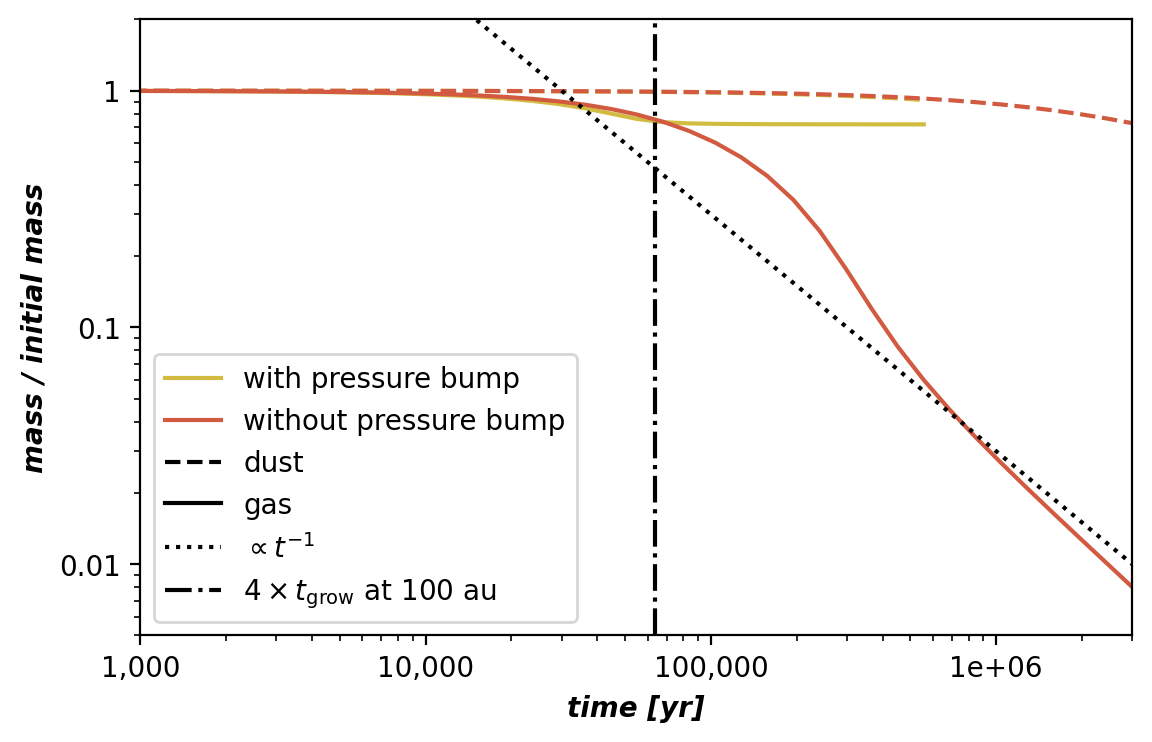

In [78]:
f, ax = plt.subplots(figsize=(6.4, 4))

for i, data_dir in enumerate(data_dirs):

    writer = dustpy.hdf5writer()
    writer.datadir = str(data_dir)
    
    data = writer.read.output(0)
    r = data.grid.r
    A = data.grid.A
    
    time = writer.read.sequence('t')
    sigg = writer.read.sequence('gas.Sigma')
    sigd = writer.read.sequence('dust.Sigma')
    
    Mg = (data.grid.A * sigg).sum(-1)
    Md = (data.grid.A * sigd.sum(-1)).sum(-1)
    
    l1, = ax.loglog(time / c.year, Mg / Mg[0], c=colors[i+1], ls='--')
    l2, = ax.loglog(time / c.year, Md / Md[0], c=colors[i+1], ls='-')

ax.set_xlabel('time [yr]')
ax.set_ylabel('mass / initial mass')

ax.loglog([], c=colors[1], label='with pressure bump')
ax.loglog([], c=colors[2], label='without pressure bump')
ax.loglog([], c='k', ls='--', label='dust')
ax.loglog([], c='k', ls='-', label='gas')
ax.loglog(time / c.year, 0.3 * ((time + 1e-100) / (1e5 * c.year))**-1, c='k', ls=':', label=r'$\propto t^{-1}$')

Ng = 4
Rg = 100
ax.axvline(np.interp(Rg * c.au, r, Ng / (data.grid.OmegaK * data.dust.eps)) / c.year, c='k', ls='-.', label=fr'${Ng} \times t_\mathrm{{grow}} \mathsf{{~at~}} {Rg}$ au')

ax.legend()

ax.set_xlim(1e3, 3e6)
ax.set_ylim(5e-3, 2)

output_file = helper.output_dir / ('mass_evolution_' + data_dir.parent.with_suffix('.pdf').name)
ax.set_facecolor('none')
helper.apply_araa_style(ax)
f.savefig(output_file, transparent=True)

## Make the frames & compile movie

In [22]:
dirname = Path('frames')
dirname.mkdir(exist_ok=True)

for i, file in tqdm(enumerate(files), total=len(files)):
    f, ax, sols = plot_quiver(file, vmin=1e-7,
                              cmap=get_transparent_cmap('cmo.algae'),
                              cols=colors, figsize=(6.4, 4))
    ax.set_xlim(right=300)
    helper.apply_araa_style(ax)
    f.savefig(dirname / f'frame_{i:03d}.jpg', transparent=False, dpi=300)

    #ax.set_facecolor('none')
    #f.savefig(dirname / f'frame_{i:03d}.png', transparent=True, dpi=300)
    
    plt.close(f)

  0%|          | 0/44 [00:00<?, ?it/s]

Transparent

In [ ]:
ret = subprocess.check_output(
    f'ffmpeg -y -r 12 -i {dirname}/frame_%03d.png -c:v prores_ks -profile:v 5 -vendor apl0  -bits_per_mb 8000 -pix_fmt yuva444p10le out_t.mov'.split(),
    stderr=subprocess.STDOUT)

Non-Transparent

In [23]:
ret = subprocess.check_output(
    f'ffmpeg -y -framerate 7 -i {dirname}/frame_%03d.jpg -c:v libx264 -crf 23 -pix_fmt yuv420p out.mp4'.split(),
    stderr=subprocess.STDOUT)

In [24]:
Video('out.mp4', width=500)